# Transfer Learning for Image Classification

## This notebook follows the structure of (TP 3 ML "Transfert Learning") step-by-step :
1. **Data Preparation** : Filters the GTSRB dataset to keep only 5 classes (to satisfy the $2 \le C \le 5$ constraint 1) and resizes images to 224x2242.
2. **Part I** : Training a custom CNN from scratch.
3. **Part II** : Transfer Learning (Feature Extraction) with MobileNetV2.
4. **Part III** : Fine-tuning the deep layers.

In [2]:
# ==========================================
# CELL 1: SETUP & DATA PREPARATION
# ==========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# --- 1. CUDA/GPU VERIFICATION ---
# Essential for ensuring the code runs fast on Kaggle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ SUCCESS: GPU detected: {gpus}")
    print("TensorFlow will automatically use CUDA for training.")
else:
    print("⚠️ WARNING: No GPU detected. Training will be slow.")
    print("Please enable 'GPU T4 x2' in the Kaggle Notebook Settings (Sidebar > Accelerator).")

# --- 2. CONFIGURATION [cite: 22] ---
IMG_HEIGHT = 224  # Standard input size for MobileNetV2
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 5   # Constraint: Keep between 2 and 5 classes 

# --- 3. DATASET DOWNLOAD ---
print("\nDownloading dataset via kagglehub...")
# Downloads the dataset to the local cache
dataset_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print(f"Dataset downloaded to: {dataset_path}")

# Define path to the training labels CSV
train_csv_path = os.path.join(dataset_path, 'Train.csv')

# --- 4. DATA FILTERING ---
df = pd.read_csv(train_csv_path)

# We select 5 distinct classes to respect the lab constraints.
# Selected IDs: 1 (30km/h), 2 (50km/h), 12 (Priority), 13 (Yield), 14 (Stop)
selected_classes = [1, 2, 12, 13, 14]

# Filter the dataframe
df = df[df['ClassId'].isin(selected_classes)]
df['ClassId'] = df['ClassId'].astype(str) # Convert to string for Keras categorical mode

# Fix image paths to be absolute
df['Path'] = df['Path'].apply(lambda x: os.path.join(dataset_path, x))

print(f"Total images after filtering: {len(df)}")
print(f"Classes retained: {selected_classes}")

# --- 5. TRAIN/VAL SPLIT [cite: 19-21] ---
# Split: 80% Train, 20% Validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['ClassId'])

# --- 6. DATA GENERATORS  ---
# Normalization (rescale=1./255) and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False # Traffic signs are direction-sensitive
)

val_datagen = ImageDataGenerator(rescale=1./255)

print("\nGenerating Training Batches...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Generating Validation Batches...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 7. UTILITY: PLOTTING FUNCTION [cite: 35-36] ---
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    plt.show()

✅ SUCCESS: GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow will automatically use CUDA for training.

Dataset downloaded to: /kaggle/input/gtsrb-german-traffic-sign
Total images after filtering: 9510
Classes retained: [1, 2, 12, 13, 14]

Generating Training Batches...
Found 7608 validated image filenames belonging to 5 classes.
Generating Validation Batches...
Found 1902 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763762139.590944      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763762139.591727      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



--- Starting Training: Baseline From Scratch ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1763762143.829153     112 service.cc:148] XLA service 0x784100004b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763762143.830310     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763762143.830334     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763762144.149258     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/238 ━━━━━━━━━━━━━━━━━━━━ 29:38 8s/step - accuracy: 0.2500 - loss: 1.5955

I0000 00:00:1763762149.355752     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


238/238 ━━━━━━━━━━━━━━━━━━━━ 126s 499ms/step - accuracy: 0.5368 - loss: 1.1307 - val_accuracy: 0.8134 - val_loss: 0.3383
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 335ms/step - accuracy: 0.7882 - loss: 0.4434 - val_accuracy: 0.8738 - val_loss: 0.2726
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 337ms/step - accuracy: 0.8254 - loss: 0.3725 - val_accuracy: 0.8496 - val_loss: 0.2781
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.8337 - loss: 0.3525 - val_accuracy: 0.8975 - val_loss: 0.2222
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 336ms/step - accuracy: 0.8638 - loss: 0.2982 - val_accuracy: 0.9022 - val_loss: 0.2143
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 336ms/step - accuracy: 0.8901 - loss: 0.2542 - val_accuracy: 0.9411 - val_loss: 0.1334
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 79s 333ms/step - accuracy: 0.9128 - loss: 0.2132 - val_accuracy: 0.9501 - val_loss: 0.1208
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.9195 - loss: 0.1840 - va

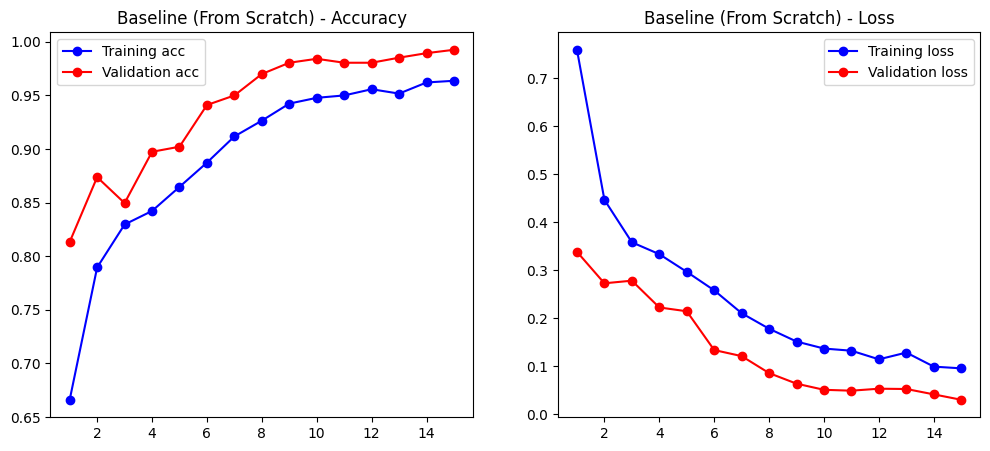

In [3]:
# ==========================================
# CELL 2: PART I - BASELINE FROM SCRATCH
# ==========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Define Architecture 
# 3 blocks of Conv+Pool followed by Dense layers
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Softmax for multi-class [cite: 33]
])

# 2. Compile
# Using Categorical Crossentropy because classes > 2
model_scratch.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# 3. Train [cite: 34]
print("\n--- Starting Training: Baseline From Scratch ---")
# With CUDA enabled, this should be reasonably fast
history_scratch = model_scratch.fit(
    train_generator,
    epochs=15, 
    validation_data=val_generator
)

# 4. Visualize Results [cite: 35-37]
plot_history(history_scratch, "Baseline (From Scratch)")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Training: Feature Extraction ---
Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 101s 387ms/step - accuracy: 0.5354 - loss: 1.1935 - val_accuracy: 0.8649 - val_loss: 0.3909
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.8328 - loss: 0.4263 - val_accuracy: 0.9033 - val_loss: 0.2742
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 347ms/step - accuracy: 0.8722 - loss: 0.3251 - val_accuracy: 0.9148 - val_loss: 0.2377
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.8866 - loss: 0.2853 - val_accuracy: 0.9206 - val_loss: 0.2063
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 83s 348ms/step - accuracy: 0.9006 - loss: 0.2498 - val_accuracy: 0.9280 - val_loss: 0.1918
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.9111 - loss: 0.2219 - val_accuracy: 0.9359 - val_loss: 0.1712
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 342ms/step - accuracy: 0.9191 - loss: 0.2092 - val_accuracy: 0.9332 - val

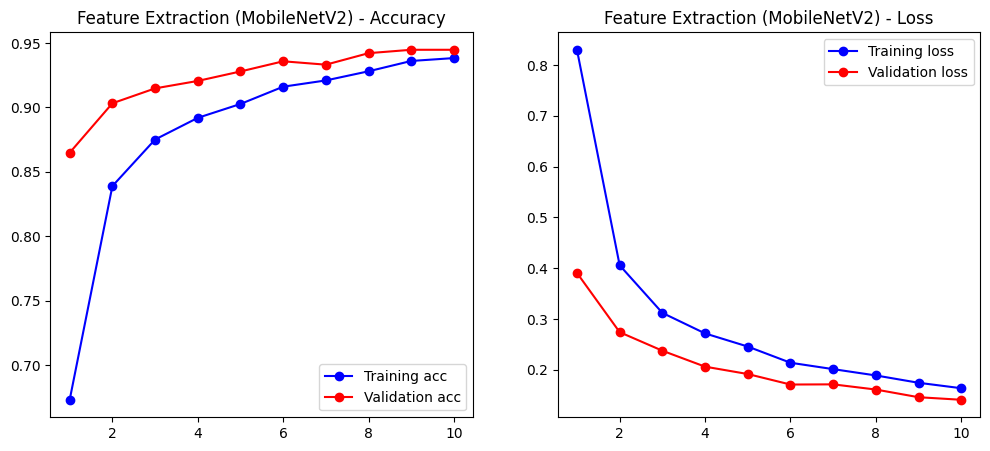

In [4]:
# ==========================================
# CELL 3: PART II - FEATURE EXTRACTION
# ==========================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 1. Load Pre-trained Model (MobileNetV2) [cite: 40]
# include_top=False removes the original 1000-class classification head
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Freeze the Base Model [cite: 41]
# We want to keep the learned weights from ImageNet intact
base_model.trainable = False

# 3. Add Custom Classification Head [cite: 42-44]
x = base_model.output
x = GlobalAveragePooling2D()(x)   # Pooling instead of Flatten
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x) # Our specific classes

model_tl = Model(inputs=base_model.input, outputs=outputs)

# 4. Compile [cite: 45-47]
# Learning rate approx 1e-4
model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 5. Train Head Only [cite: 48]
print("\n--- Starting Training: Feature Extraction ---")
history_tl = model_tl.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 6. Visualize Results [cite: 49]
plot_history(history_tl, "Feature Extraction (MobileNetV2)")

Number of layers in base model: 154
Layers frozen: 124
Layers training: 30

--- Starting Training: Fine-Tuning ---
Epoch 10/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 375ms/step - accuracy: 0.8487 - loss: 0.3912 - val_accuracy: 0.9448 - val_loss: 0.1339
Epoch 11/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 335ms/step - accuracy: 0.9317 - loss: 0.1910 - val_accuracy: 0.9579 - val_loss: 0.1081
Epoch 12/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.9523 - loss: 0.1414 - val_accuracy: 0.9637 - val_loss: 0.0948
Epoch 13/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 338ms/step - accuracy: 0.9651 - loss: 0.1071 - val_accuracy: 0.9632 - val_loss: 0.0827
Epoch 14/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 341ms/step - accuracy: 0.9655 - loss: 0.0971 - val_accuracy: 0.9711 - val_loss: 0.0711
Epoch 15/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.9697 - loss: 0.0816 - val_accuracy: 0.9779 - val_loss: 0.0590
Epoch 16/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 340ms/step - accuracy: 0.9742 - loss: 0.0749 - 

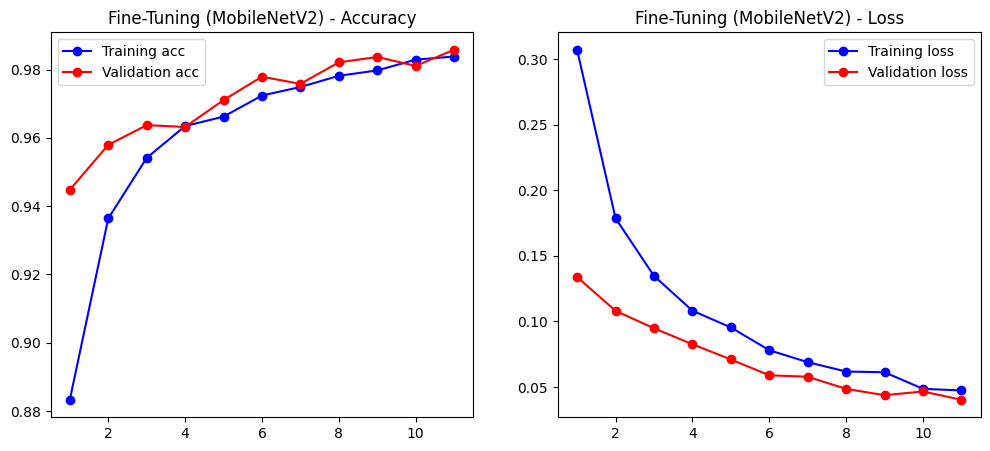

In [5]:
# ==========================================
# CELL 4: PART III - FINE-TUNING
# ==========================================

# 1. Unfreeze the Base Model
base_model.trainable = True

# 2. Freeze Early Layers [cite: 56-58]
# We only want to retrain the last specific layers (high-level features)
# MobileNetV2 has many layers; let's fine-tune the last 30.
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Number of layers in base model: {len(base_model.layers)}")
print(f"Layers frozen: {fine_tune_at}")
print(f"Layers training: {len(base_model.layers) - fine_tune_at}")

# 3. Recompile with Low Learning Rate [cite: 59]
# Critical: Use a very small LR (1e-5) to avoid destroying the weights
model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 4. Continue Training [cite: 60]
print("\n--- Starting Training: Fine-Tuning ---")
# Total epochs = Previous epochs + New fine-tuning epochs
total_epochs = 20 

history_ft = model_tl.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_tl.epoch[-1], # Resume where we left off
    validation_data=val_generator
)

# 5. Visualize Results [cite: 60]
plot_history(history_ft, "Fine-Tuning (MobileNetV2)")


=== FINAL RESULTS TABLE FOR REPORT ===
                Model Approach Best Val Accuracy Best Val Loss  \
0      Baseline (From Scratch)            0.9926        0.0297   
1  Feature Extraction (Frozen)            0.9448        0.1411   
2       Fine-Tuning (Unfrozen)            0.9858        0.0403   

   Training Epochs  
0               15  
1               10  
2               10  


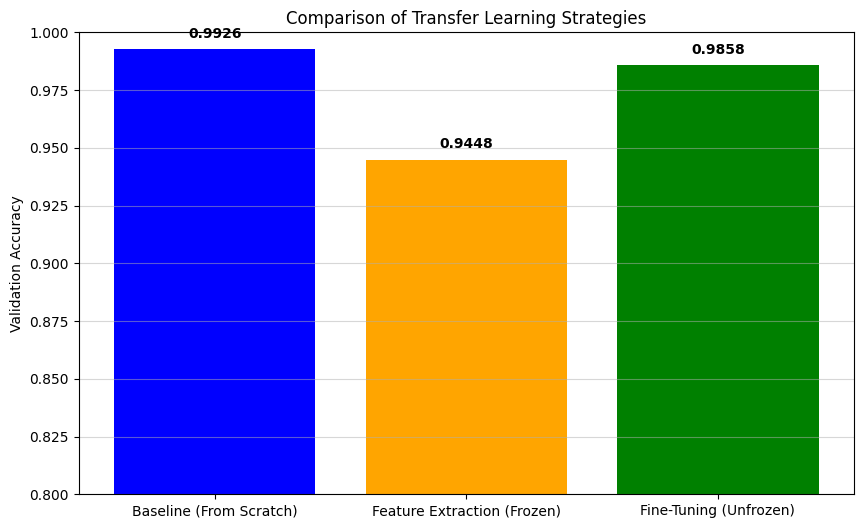

In [6]:
# ==========================================
# CELL 5: GLOBAL COMPARISON & RESULTS [cite: 62-63]
# ==========================================

# 1. Retrieve best results from histories
acc_scratch = max(history_scratch.history['val_accuracy'])
acc_fe = max(history_tl.history['val_accuracy'])
acc_ft = max(history_ft.history['val_accuracy'])

loss_scratch = min(history_scratch.history['val_loss'])
loss_fe = min(history_tl.history['val_loss'])
loss_ft = min(history_ft.history['val_loss'])

# 2. Create DataFrame
results_df = pd.DataFrame({
    'Model Approach': ['Baseline (From Scratch)', 'Feature Extraction (Frozen)', 'Fine-Tuning (Unfrozen)'],
    'Best Val Accuracy': [f"{acc_scratch:.4f}", f"{acc_fe:.4f}", f"{acc_ft:.4f}"],
    'Best Val Loss': [f"{loss_scratch:.4f}", f"{loss_fe:.4f}", f"{loss_ft:.4f}"],
    'Training Epochs': [15, 10, 10] 
})

print("\n=== FINAL RESULTS TABLE FOR REPORT ===")
print(results_df)

# 3. Visual Comparison Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model Approach'], [float(x) for x in results_df['Best Val Accuracy']], color=['blue', 'orange', 'green'])
plt.ylim(0.8, 1.0) # Zoom in to see differences
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Transfer Learning Strategies')
plt.grid(axis='y', alpha=0.5)
for i, v in enumerate([float(x) for x in results_df['Best Val Accuracy']]):
    plt.text(i, v + 0.005, str(v), ha='center', fontweight='bold')
plt.show()

In [7]:
# Check if models are defined before saving
if 'model_scratch' in globals():
    model_scratch.save('modele_baseline_gtsrb.keras')
    print("✅ Baseline model saved: modele_baseline_gtsrb.keras")
else:
    print("❌ Error: 'model_scratch' is not defined. Please run Cell 2 first.")

if 'model_tl' in globals():
    model_tl.save('modele_mobilenetv2_finetuned.keras')
    print("✅ Fine-Tuned model saved: modele_mobilenetv2_finetuned.keras")
else:
    print("❌ Error: 'model_tl' is not defined. Please run Cell 3 and 4 first.")

✅ Baseline model saved: modele_baseline_gtsrb.keras
✅ Fine-Tuned model saved: modele_mobilenetv2_finetuned.keras


In [8]:
# ==========================================
# CELL 6: SAVE MODELS
# ==========================================
import os
import zipfile

print("--- Saving models ---")

# 1. Save Baseline Model (From Scratch)
# The .keras format is the new standard recommended by TensorFlow
if 'model_scratch' in globals():
    model_scratch.save('modele_baseline_gtsrb.keras')
    print("Model Baseline saved: modele_baseline_gtsrb.keras")
else:
    print("Error: model_scratch is not defined. Please run Cell 2 first.")

# 2. Save Final Model (Transfer Learning + Fine-Tuning)
# Note: model_tl now contains the weights after Fine-Tuning
if 'model_tl' in globals():
    model_tl.save('modele_mobilenetv2_finetuned.keras')
    print("Fine-Tuned Model saved: modele_mobilenetv2_finetuned.keras")
else:
    print("Error: model_tl is not defined. Please run Cell 3 and 4 first.")

# --- OPTIONAL: CREATE A ZIP FOR EASY DOWNLOAD ON KAGGLE ---
# On Kaggle, it is sometimes easier to download a single ZIP file
def zip_files(output_filename, files_to_zip):
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        for file in files_to_zip:
            if os.path.exists(file):
                zipf.write(file)
                print(f"Added to zip: {file}")
            else:
                print(f"File not found: {file}")

files = ['modele_baseline_gtsrb.keras', 'modele_mobilenetv2_finetuned.keras']
zip_files('mes_modeles_gtsrb.zip', files)

print("\nAll set! You can download 'mes_modeles_gtsrb.zip' from the Output section.")

--- Saving models ---
Model Baseline saved: modele_baseline_gtsrb.keras
Fine-Tuned Model saved: modele_mobilenetv2_finetuned.keras
Added to zip: modele_baseline_gtsrb.keras
Added to zip: modele_mobilenetv2_finetuned.keras

All set! You can download 'mes_modeles_gtsrb.zip' from the Output section.
